## Complexity, information loss and accuracy for Dutch

In [1]:
import pandas as pd 

df = pd.read_excel('../kinship_dutch.xlsx')
df

,Target group,Dutch words,Count
0,"MM, FM",Grootmoeder,1058
1,NaN,Oma,1097
2,"MF, FF",Grootvader,1440
3,NaN,Opa,723
4,F,Vader,19939
5,NaN,Papa,896
6,NaN,Pa,1346
7,M,Moeder,18009
8,NaN,Mama,1511
9,NaN,Ma,1186


In [2]:
from pandas import isna

counts = []
all_u = set()
all_w = set()

# collect counts
for _, row in df.iterrows():
    w = row['Dutch words']
    us = row['Target group']
    if isna(us):
        continue # us = counts[-1][0] -- discard synonyms 
    else: 
        us = [u.strip() for u in us.split(',')]
    counts.append((us, row['Dutch words'], row['Count']))
    all_u.update(set(us))
    all_w.add(w)
    
print('counts')
display(counts)

counts


[(['MM', 'FM'], 'Grootmoeder', 1058),
 (['MF', 'FF'], 'Grootvader', 1440),
 (['F'], 'Vader', 19939),
 (['M'], 'Moeder', 18009),
 (['MZy', 'MZe', 'FZy', 'FZe'], 'Tante', 819),
 (['MBy', 'MBe', 'FBy', 'FBe'], 'Oom', 1018),
 (['Zy', 'Ze'], 'Zus', 4059),
 (['By', 'Be'], 'Broer', 5936),
 (['D'], 'Dochter', 10378),
 (['S'], 'Zoon', 8737),
 (['DD', 'SD'], 'Kleindochter', 174),
 (['DS', 'SS'], 'Kleinzoon', 234),
 (['ZyD', 'ByD', 'ZeD', 'ByD'], 'Nicht', 287),
 (['ZyS', 'ByS', 'ZeS', 'ByS'], 'Neef', 711)]

In [3]:
new_counts = {}
for us, w, c in counts:
    for u in us:
        new_counts[u] = c/len(us)
new_counts

{'MM': 529.0,
 'FM': 529.0,
 'MF': 720.0,
 'FF': 720.0,
 'F': 19939.0,
 'M': 18009.0,
 'MZy': 204.75,
 'MZe': 204.75,
 'FZy': 204.75,
 'FZe': 204.75,
 'MBy': 254.5,
 'MBe': 254.5,
 'FBy': 254.5,
 'FBe': 254.5,
 'Zy': 2029.5,
 'Ze': 2029.5,
 'By': 2968.0,
 'Be': 2968.0,
 'D': 10378.0,
 'S': 8737.0,
 'DD': 87.0,
 'SD': 87.0,
 'DS': 117.0,
 'SS': 117.0,
 'ZyD': 71.75,
 'ByD': 71.75,
 'ZeD': 71.75,
 'ZyS': 177.75,
 'ByS': 177.75,
 'ZeS': 177.75}

In [4]:
from collections import defaultdict
from itertools import product
from math import log2


def estimate_prob_given_count(counts):
    # collect counts with conditions
    count_u = defaultdict(lambda: 1e-10)  # for p(u)
    count_w_u = defaultdict(lambda: defaultdict(lambda: 1e-10))  # for p(w|u)
    count_u_w = defaultdict(lambda: defaultdict(lambda: 1e-10))  # for p(u|w)
    
    for us, w, c in counts:
        for u in us:
            count_u[u] += c / len(us)
            count_w_u[u][w] += c
            count_u_w[w][u] += c / len(us)
    
    # estimate prob p(u), p(w|u), p(u|w)
    p_u = defaultdict(lambda: 1e-10, {u:count_u[u] / sum(count_u.values()) for u in count_u.keys()})
    
    p_w_u = defaultdict(lambda: defaultdict(lambda: 1e-10), {
        u:defaultdict(lambda: 1e-10, {
            w:count_w_u[u][w] / sum(count_w_u[u].values())
            for w in count_w_u[u].keys()
        })
        for u in count_w_u.keys()})
    
    p_u_w = defaultdict(lambda: defaultdict(lambda: 1e-10), {
        w:defaultdict(lambda: 1e-10, {
            u:count_u_w[w][u] / sum(count_u_w[w].values())
            for u in count_u_w[w].keys()
        })
        for w in count_u_w.keys()})
    
    return p_u, p_w_u, p_u_w


def compute_complexity_infoloss_accuracy(
    all_u, all_w, 
    p_u, 
    p_sender_w_u, p_sender_u_w, 
    p_receiver_u_w
):
    complexity = 0  # I(W,U) = sum_u_w p(u) x p(w|u) x log2( p(u|w) / p(u) ) 
    for u, w in product(all_u, all_w):
        cplx = (
            p_u[u] * 
            p_sender_w_u[u][w] * 
            log2(p_sender_u_w[w][u] / p_u[u] + 1e-10)
        )
        complexity += cplx
        
    info_loss = 0  # -sum_u_w p(u) x p(w|u) x log2(p(u|w))
    for u, w in product(all_u, all_w):
        info_loss += -p_u[u] * p_sender_w_u[u][w] * log2(p_receiver_u_w[w][u] + 1e-10)
    
    acc = 0  # 
    for u, w in product(all_u, all_w): 
        acc += p_u[u] * p_sender_w_u[u][w] * p_receiver_u_w[w][u]
    
    return {
        'complexity': complexity,
        'info loss': info_loss,
        'accuracy': acc
    }


In [5]:
p_u, p_w_u, p_u_w = estimate_prob_given_count(counts)
dutch = compute_complexity_infoloss_accuracy(
    all_u, all_w,
    p_u, 
    p_w_u, 
    p_u_w, 
    p_u_w
)
display(dutch)

{'complexity': 2.8088414191179143,
 'info loss': 0.24824520990325472,
 'accuracy': 0.88389950411405}

## Complexity, information loss, accuracy for emergent language
Using Dutch's need probabilities

In [6]:
import json
import numpy as np 

# read evalutaion file 
def process_one_file(path: str):
    all_df = pd.read_csv(path)
    eme_lang = []
    
    for epoch in range(5, 1000, 5):
        df = all_df[all_df.Epoch == epoch]
        if df.shape[0] == 0:
            continue
        
        # estimate counts with weights 
        counts_sender = []
        all_u = set()
        all_w = set()
        for _, row in df.iterrows(): 
            if True: # row['Ego Node'] == 'Alice':
                u, w = row['Target Node'], row['Message']
                counts_sender.append(([u], w, p_u[u]))  # assume that a target has only one name
                all_u.add(u)
                all_w.add(w)
        p_sender_u, p_sender_w_u, p_sender_u_w = estimate_prob_given_count(counts_sender)
        for u, p in p_u.items():
            assert abs(p_sender_u[u] - p) < 1e-5, f"{[u, p, p_sender_u[u]]}"
        p_receiver_u_w = defaultdict(lambda: defaultdict(lambda: 1e-10))
        for _, row in df.iterrows(): 
            idx, u, w = row['Target Node Idx'], row['Target Node'], row['Message']
            receiver_output = np.array(json.loads(row['Receiver Output']))
            if len(receiver_output.shape) > 1:
                receiver_output = receiver_output[0]
            p_receiver_u_w[w][u] = receiver_output[idx]
    
        eme_lang.append(
            compute_complexity_infoloss_accuracy(
                all_u, all_w,
                p_u, 
                p_sender_w_u, 
                p_sender_u_w, 
                p_receiver_u_w
            )
        )
    return eme_lang

In [7]:
eme_langs = {}
eme_langs[100] = process_one_file('results/uniform100/evaluation.csv')
eme_langs[100]

[{'complexity': 1.5706248668020146,
  'info loss': 2.29125465247611,
  'accuracy': 0.3229841177469784},
 {'complexity': 1.8765641833389795,
  'info loss': 1.8979879307329093,
  'accuracy': 0.3338377521608663},
 {'complexity': 2.0978054712892864,
  'info loss': 1.594615963474012,
  'accuracy': 0.4127445663813237},
 {'complexity': 2.1194915473167772,
  'info loss': 1.608587947383966,
  'accuracy': 0.4419209502070009},
 {'complexity': 2.0725680163566853,
  'info loss': 1.1261301578414364,
  'accuracy': 0.4856607433732239},
 {'complexity': 2.203683840822771,
  'info loss': 0.990045089685111,
  'accuracy': 0.5419859428118518},
 {'complexity': 2.550391471761236,
  'info loss': 1.367881908104152,
  'accuracy': 0.6518047644801146},
 {'complexity': 2.5907807670078173,
  'info loss': 0.8137310458632983,
  'accuracy': 0.7207710292163557},
 {'complexity': 2.545124281751209,
  'info loss': 1.3024390531410825,
  'accuracy': 0.7113069191981153},
 {'complexity': 2.4680074568109656,
  'info loss': 1.10

## Plot

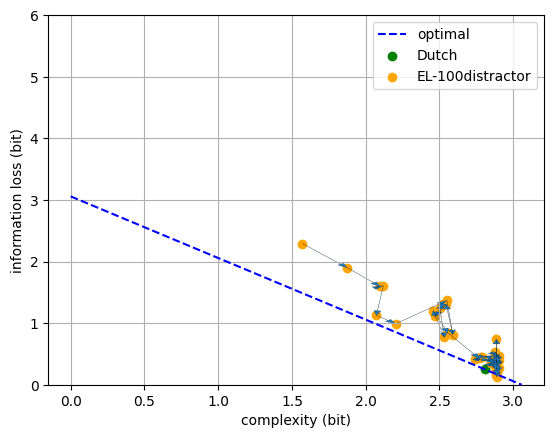

In [8]:
from matplotlib import pyplot as plt
# information loss = - complexity + entropy(u)

entropy_u = sum(-p_u[u] * log2(p_u[u] + 1e-10) for u in p_u.keys())
plt.plot([0, entropy_u], [entropy_u, 0], '--b')
plt.scatter([dutch['complexity']], [dutch['info loss']], color='green')

for eme_lang, color in zip(eme_langs.values(), ['orange', 'red', 'black', 'purple']):
    plt.scatter(
        [x['complexity'] for x in eme_lang], 
        [x['info loss'] for x in eme_lang], 
        color=color
    )

for eme_lang in eme_langs.values():
    for i in range(len(eme_lang)):
        l1, l2 = eme_lang[i-1], eme_lang[i]
        if i > 0: 
            plt.arrow(
                l1['complexity'], l1['info loss'], 
                l2['complexity'] - l1['complexity'],
                l2['info loss'] - l1['info loss'],
                shape='full', lw=0.1, length_includes_head=True, head_width=.05
            )

plt.xlabel('complexity (bit)')
plt.ylabel('information loss (bit)')
plt.legend(['optimal', 'Dutch'] + [f'EL-{n}distractor' for n in eme_langs.keys()])
plt.ylim(0, 6)
plt.grid()
plt.show()